In [1]:
import os
import gc
import math 
import sklearn
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime

## Read and preprocess data

In [2]:
### Read

In [3]:
path = '/Users/nguyenhuyhai/202224/NEST_QUANT/data/'
path_ETHUSDT = path+ '/coin/ETHUSDT'
path_LTCUSDT = path+ '/coin/LTCUSDT'
path_CPILFESL = path + '/FRED/CPILFESL.parquet'
path_EURUSD = path + '/fx/C_EURUSD'
path_SPY = path+'/stock/SPY'

def get_return(df, time, name):
    dff = df.copy()
    dff[f'RETURN_{name}_{time}'] = np.log(dff[f'CLOSE_{name}'] / dff[f'CLOSE_{name}'].shift(time))
    return dff

def get_vola(df, time, isReturn, name):
    dff = df.copy()
    if isReturn == False:
        dff = get_return(dff, 1)
    dff[f"std_{time}"] = dff[f'RETURN_{name}_1'].rolling(window=time).std()
    dff["std_long"] = dff[f'RETURN_{name}_1'].rolling(window=336).std()
    dff[f"VOLABILITY_{name}_{time}"]  = dff[f"std_{time}"]/ dff["std_long"]

    dff = dff.drop(f"std_{time}", axis = 1)
    dff = dff.drop("std_long", axis = 1)

    return dff


def preprocess_df(df, name, start, end): 
    for col in df.columns:
        if (col == 'YEAR_AND_MONTH') | (col =="SYMBOL"):
            df = df.drop(col, axis = 1)
        else:
            df[f'{col}_{name}'] = df[col]
            df = df.drop(col, axis = 1)

    for i in range(start, end):
        df = get_return(df, i, name) 
        if i == 1:
            continue
        else:
            df = get_vola(df, i, True, name) 
    
    return df


# Original dataframe
def get_dupp(dff):
# Convert the 'date' column to datetime type
    dff['DATE'] = pd.to_datetime(dff['DATE'])

    # Create a new dataframe to store the expanded rows
    expanded_dff = pd.DataFrame()

    # Iterate over each row in the original dataframe
    for index, row in dff.iterrows():
        date = row['DATE']
        values = row[1:]  # Exclude the 'date' column
        
        # Create a datetime range for the 24 hours of the day
        hour_range = pd.date_range(date, periods=24, freq='H')
        
        # Create a temporary dataframe with the expanded rows
        temp_dff = pd.DataFrame(hour_range, columns=['DATE'])
        
        # Duplicate the values for each hour
        for column, value in zip(dff.columns[1:], values):
            temp_dff[column] = value
        
        # Append the temporary dataframe to the expanded dataframe
        expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
    return expanded_dff

In [4]:
### Preprocess

In [5]:
df_BTC = pd.read_parquet(path+'parquet/BTCUSDT')
df_Label = pd.read_parquet(path+'parquet/SYMBOL=BTCUSDT.parquet')

df_BTCLabel = df_BTC.join(df_Label, how='inner')
df_BTCLabel = df_BTCLabel.drop(columns=["YEAR_AND_MONTH","SYMBOL"])
df_BTCLabel = preprocess_df(df_BTCLabel, "BTC",1, 24)
df_ETHUSDT = preprocess_df(pd.read_parquet(path_ETHUSDT),"ETHUSDT", 1, 24)
df_LTCUSDT = preprocess_df(pd.read_parquet(path_LTCUSDT),"LTCUSDT",1, 24)
#df_CPILFESL = preprocess_df(pd.read_parquet(path_CPILFESL))
df_EURUSD = preprocess_df(pd.read_parquet(path_EURUSD),"EURUSD", 1, 24)
df_SPY = preprocess_df(pd.read_parquet(path_SPY),"SPY", 1, 24)

df_BTCLabel = df_BTCLabel.dropna()
df_ETHUSDT = df_ETHUSDT.dropna()
df_LTCUSDT = df_LTCUSDT.dropna()
df_EURUSD = df_EURUSD.dropna()
df_SPY = df_SPY.dropna()


df_CPILFESL = pd.read_parquet(path_CPILFESL)
df_CPILFESL = get_dupp(df_CPILFESL)
df_CPILFESL["OPEN_TIME"] = df_CPILFESL["DATE"].apply(lambda x: int(datetime.timestamp(x)) *1000)
df_CPILFESL = df_CPILFESL.drop("DATE", axis= 1)
df_CPILFESL = df_CPILFESL.set_index("OPEN_TIME")


df_BTCLabel1 = df_BTCLabel.join(df_ETHUSDT, how = 'inner')
df_BTCLabel2 = df_BTCLabel1.join(df_EURUSD, how="left").bfill().ffill()
df_BTCLabel3 = df_BTCLabel2.join(df_LTCUSDT, how="left").bfill().ffill()
df_BTCLabel4 = df_BTCLabel3.join(df_SPY, how="left").bfill().ffill()
df_BTCLabel5 = df_BTCLabel4.join(df_CPILFESL, how="left").bfill().ffill().reset_index()

/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_18282/291147599.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_18282/291147599.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_18282/291147599.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_18282/291147599.py:69: FutureWarning: The frame.append method is deprecated and will be removed fr

In [6]:
df_BTCLabel5

,OPEN_TIME,OPEN_BTC,HIGH_BTC,LOW_BTC,CLOSE_BTC,VOLUME_BTC,QUOTE_ASSET_VOLUME_BTC,NUMBER_OF_TRADES_BTC,TAKER_BUY_BASE_ASSET_VOLUME_BTC,TAKER_BUY_QUOTE_ASSET_VOLUME_BTC,...,VOLABILITY_SPY_19,RETURN_SPY_20,VOLABILITY_SPY_20,RETURN_SPY_21,VOLABILITY_SPY_21,RETURN_SPY_22,VOLABILITY_SPY_22,RETURN_SPY_23,VOLABILITY_SPY_23,VALUE
0,1.506766e+12,4280.00,4280.00,4266.12,4266.24,0.526956,2.251295e+03,11,0.000000,0.000000e+00,...,0.691034,0.000796,0.709185,0.000796,0.692483,0.000676,0.694700,0.000398,0.745985,253.428
1,1.506769e+12,4340.00,4340.00,4315.13,4315.14,6.174607,2.677750e+04,108,2.335674,1.013649e+04,...,0.691034,0.000796,0.709185,0.000796,0.692483,0.000676,0.694700,0.000398,0.745985,253.428
2,1.506773e+12,4320.21,4324.99,4320.21,4320.21,1.105973,4.779179e+03,8,0.230058,9.949985e+02,...,0.691034,0.000796,0.709185,0.000796,0.692483,0.000676,0.694700,0.000398,0.745985,253.428
3,1.506776e+12,4306.00,4322.19,4300.00,4310.00,3.584590,1.543893e+04,107,0.930119,4.012274e+03,...,0.691034,0.000796,0.709185,0.000796,0.692483,0.000676,0.694700,0.000398,0.745985,253.428
4,1.506780e+12,4286.82,4297.29,4286.62,4286.62,1.840831,7.898877e+03,15,0.000000,0.000000e+00,...,0.691034,0.000796,0.709185,0.000796,0.692483,0.000676,0.694700,0.000398,0.745985,253.428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47321,1.677611e+12,23481.63,23492.84,23472.24,23473.37,634.810840,1.490652e+07,27420,298.291320,7.004613e+06,...,0.713270,0.001731,0.697518,0.001859,0.680035,0.002347,0.680088,0.002975,0.690884,305.240
47322,1.677614e+12,23263.38,23272.46,23167.15,23189.26,2865.914520,6.652689e+07,66824,1252.804130,2.908068e+07,...,0.680274,-0.003575,0.668552,-0.002926,0.721629,-0.003139,0.704755,-0.003340,0.688863,305.240
47323,1.677618e+12,23270.59,23277.98,23192.12,23209.65,1829.575030,4.252433e+07,57949,867.875200,2.017225e+07,...,1.186287,-0.006508,1.155474,-0.006269,1.144427,-0.006847,1.121153,-0.006796,1.102433,305.240
47324,1.677622e+12,23138.89,23173.84,23094.69,23164.41,1371.824500,3.173706e+07,40889,703.061520,1.626665e+07,...,1.262785,-0.003429,1.236003,-0.003907,1.210818,-0.004121,1.181687,-0.004348,1.154612,305.240


In [7]:
df_BTCLabel5 = df_BTCLabel5[["OPEN_TIME","OPEN_BTC","HIGH_LTCUSDT","VOLABILITY_BTC_23","LABEL_BTC"]]

In [10]:
x = df_BTCLabel5.drop(['LABEL_BTC'],axis=1)
y = df_BTCLabel5["LABEL_BTC"]

# train and test split
# x,_,y,_ = train_test_split(x,y,test_size=0.01, shuffle=False)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1, shuffle=False)


In [11]:
path_to_load_models = '/Users/nguyenhuyhai/202224/NEST_QUANT/model_tests/ML_models/UpdatedBestmodel.txt'
model = lgb.Booster(model_file=path_to_load_models)

In [12]:
x_test

,OPEN_TIME,OPEN_BTC,HIGH_LTCUSDT,VOLABILITY_BTC_23
42593,1.660590e+12,24098.22,60.91,1.320533
42594,1.660594e+12,23983.54,60.82,1.327271
42595,1.660597e+12,24068.36,60.90,1.335188
42596,1.660601e+12,24027.43,60.65,1.339145
42597,1.660604e+12,24013.72,60.23,1.358235
...,...,...,...,...
47321,1.677611e+12,23481.63,95.15,0.500673
47322,1.677614e+12,23263.38,94.64,0.634515
47323,1.677618e+12,23270.59,94.22,0.622967
47324,1.677622e+12,23138.89,93.52,0.612269


In [13]:
pred=model.predict(x_test)

testt=pd.DataFrame(columns=['TEST','PREDICTION'])

testt['TEST']=y_test
testt['PREDICTION']=pred.flatten()


In [14]:
testt

,TEST,PREDICTION
42593,0.401599,0.472000
42594,0.405856,0.476072
42595,0.406372,0.466066
42596,0.395813,0.470064
42597,0.391707,0.466133
...,...,...
47321,0.448246,0.446735
47322,0.470401,0.451132
47323,0.468764,0.452519
47324,0.474988,0.455385


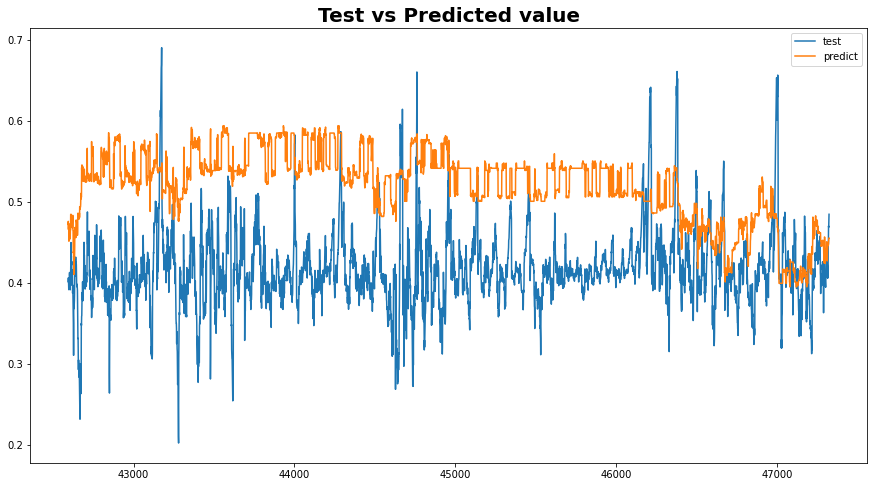

In [15]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(testt)
plt.legend(['test','predict'])


In [16]:
testt.corr()

,TEST,PREDICTION
TEST,1.000000,0.039486
PREDICTION,0.039486,1.000000
